In [7]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Thu May 12 16:35:28 2016

@author: bartz
"""
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
#from __future__ import division
import numpy as np
import sklearn
print (sklearn.__version__)
## version must be at least 0.18.1
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score 
import pandas as pd
import math
from IPython.display import set_matplotlib_formats

0.19.2


In [8]:
plt.style.use('ggplot')

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"


np.random.seed(0) # seed to shuffle the train set   # random gefällt mir nicht zu schnell neue werte vergleichbarkeit wird erschwert
n_folds = 10  

In [9]:
class Function:
    def __init__(self, func, name="no-name"):
        self.func = func
        self.name = name

    def __call__(self, *args):
        return self.func(*args)


fList = [
    Function(lambda x: -2 * (x < -3) + 2.55 * (x > -2) - 2 * (x > 0) + 4 * (x > 2) - 1 * (x > 3) ,"step"),
    Function(lambda x: 6 + 0.4 * x - 0.36 * x**2 + 0.005 * x**3, "quadratic"),
    Function(lambda x: 2.83 * np.sin(math.pi/2 * x), "sinus") ,
    Function(lambda x: 4.0 * np.sin(3 * math.pi * x) * (x >= 0), "combined lin and sin"),
    Function(lambda x: x, "identity"),
    Function(lambda x: np.random.normal(-1, 1, len(x)), "random"),
]


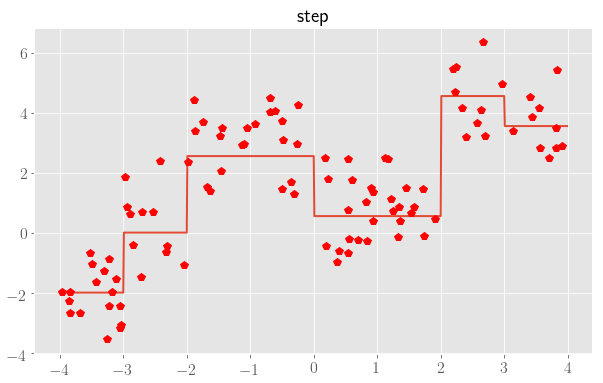

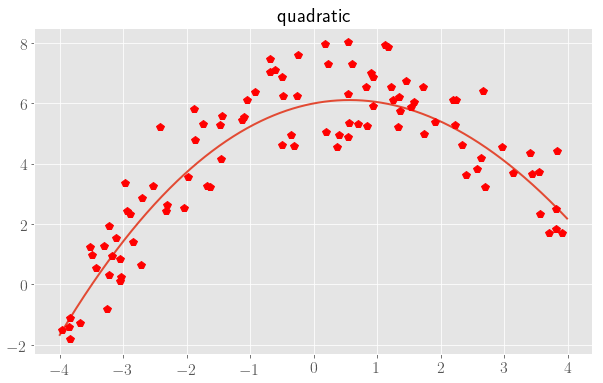

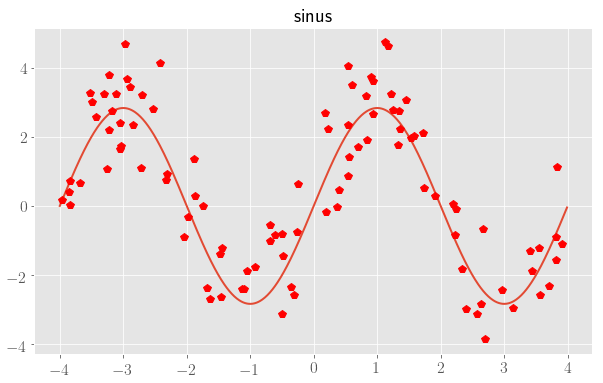

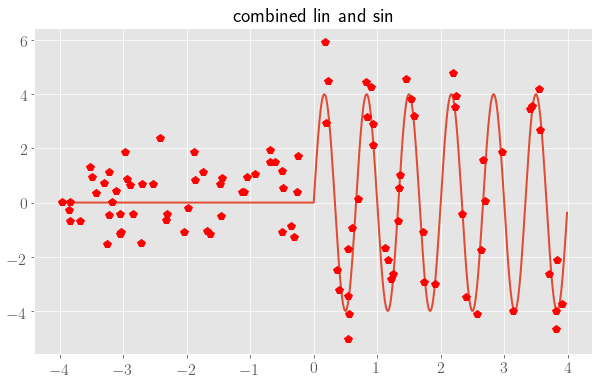

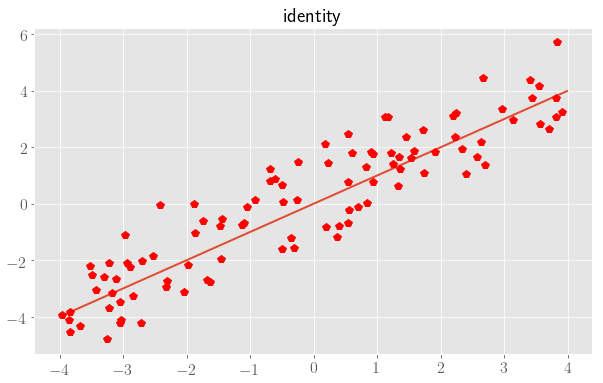

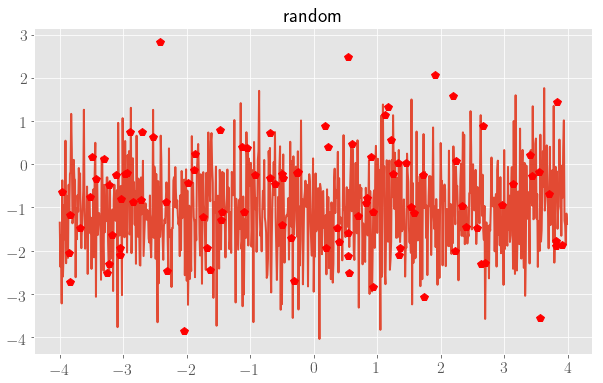

In [10]:
x = np.random.uniform(-4, 4, 100) 
t = np.arange(-4.0, 4.0, 0.01)
err = np.random.normal(0, 1, 100)
for func in fList:
    yt = func(t)
    yerr = func(x) + err
    plt.plot(t, yt, x, yerr, 'rp')
    plt.title(func.name)
    plt.show()

## Cross Validation Algorithm

Schauen ob das so passt und ob dies eine Korrekte implementation des Cross Validation Algorithmus ist.
Ps. Rückgabewerte sind mir noch seltsam 

In [11]:
def cross_validation(x, y, regressors, n_folds=10):
    skf = KFold(n_folds)
    skf.get_n_splits(x, y)
    ycv = np.zeros((x.shape[0], len(regressors)))  # value for each prediction
    ybt = np.zeros((x_test.shape[0], len(regressors)))  # score for how well for the complete avg

    for j, regressor in enumerate(regressors):
        ybt_j = np.zeros((x_test.shape[0], n_folds))
        for i, (train, test) in enumerate((skf.split(x, y))):
            # data preparation for the Model
            x_train = x[train,]
            y_train = y[train]
            x_val_test = x[test]

            regressor.fit(x_train, y_train)
            ycv[test, j] = regressor.predict(x_val_test)  # YCV saves the Prediction

            ybt_j[:, i] = regressor.predict(x_test)  # YBT saves also the prediction for later calculation
        ybt[:, j] = ybt_j.mean(1)  # mean of all splits
    return ybt, ycv


## New Experiment Function Definition 

Bessere Funktion daten werden übergeben und mit diesen wird das Experiment dann Durchgeführt

Überlegungen

Andere Bennenung der Funktion experiment ist zu generisch vieleicht Stacked
Generalisation oder LinearStacked Generalsisation ist besser als experiment denn
das könnte alles sein. auserdem r2 Score vielleicht rausziehen falls möglich ?
sodass einfacherer andere Scoring verfahren verwendet werden können.

vielleicht push statt index zugriff ? macht die sache einfacher ??

andere Regressor für die Gewichtung der Modelle ??


In [87]:
def n_experiment(x, y, x_test, y_test, regressors, repeats=1, n_folds=10):
    R = np.zeros((len(regressors) + 1, repeats))
    C = np.zeros((len(regressors) + 1, repeats))

    for r in range(repeats):
        ybt, ycv = cross_validation(x, y, regressors, n_folds)

        # use Linear Regression for weighted Essamble (C and R Values)
        reg = LinearRegression()
        reg.fit(ycv, y)  
        C[0, r] = reg.intercept_
        C[range(1, 1 + len(regressors)), r] = reg.coef_  # the weights for the regressors

        # r2_socre scoring function 1.0 is best value
        r2 = r2_score(y_test, reg.predict(ybt))  # see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html


        R[0, r] = r2

        x = np.array(x).reshape((len(x), 1))
        for j, reg in enumerate(regressors):
            reg.fit(x, y)  # frage: isn't it unrealistic to use y without error here ?
            r2 = r2_score(y_test, reg.predict(x_test))
            R[j + 1, r] = r2  # wo ist der score des gesamten modells statt nur der Teilmodelle
    return {"C": C, "R": R}


In [12]:
function_to_predict = fList[0]
# calculate data
np.random.seed(1721993)
err = np.random.normal(0, 1, 500)

np.random.seed(0)
x = np.random.uniform(-4, 4, 500)


y = function_to_predict(x)# + err

regressors = [
    LinearRegression(),
    RandomForestRegressor(),
    GaussianProcessRegressor()]

# calculate data

x = x.reshape((len(x), 1))
x, x_test = np.split(x, 2)
y, y_test = np.split(y, 2)

result = n_experiment(x, y, x_test, y_test, regressors)

C = result["C"]
R = result["R"]
print(result)

if np.allclose(C, np.array([[0.00547911],
                            [-0.00188262],
                            [1.05872036],
                            [-0.06062416]])) \
        and np.allclose(R, np.array([[0.99228788],
                                     [0.52345957],
                                     [0.99215012],
                                     [0.95322735]])):
    print("same res")




NameError: name 'n_experiment' is not defined

## Old Experiment Function Definition 

In [13]:
def experiment(regressors, function_to_predict, repeats=100, n_folds=10):
    R = np.zeros((len(regressors) + 1, repeats))
    C = np.zeros((len(regressors) + 1, repeats))

    for r in range(repeats):

        # calculate data
        np.random.seed(r)
        x = np.random.uniform(-4, 4, 100)
        y = function_to_predict(x)
        x_test = np.random.uniform(-4, 4, 100)
        y_test = function_to_predict(x_test)

        #preparation for cross validation
        skf = KFold(n_folds)
        skf.get_n_splits(x, y)

        ycv = np.zeros((x.shape[0], len(regressors)))  # value for each prediction
        ybt = np.zeros((x_test.shape[0], len(regressors)))  # score for how well for the complete avg
        # Cross Validation
        for j, regressor in enumerate(regressors):
            ybt_j = np.zeros((x_test.shape[0], n_folds))
            for i, (train, test) in enumerate(list(skf.split(x, y))): 

                # data preparation for the Model
                # maybe Calculate once and save is faster then transforming it every time
                x_train = x[train, ]
                x_train = np.array(x_train).reshape((len(x_train), 1))
                y_train = y[train]
                x_val_test = x[test]
                x_val_test = np.array(x_val_test).reshape((len(x_val_test), 1))

                regressor.fit(x_train, y_train)
                ycv[test, j] = regressor.predict(x_val_test)  # YCV saves the Prediction
                x_test = np.array(x_test).reshape((len(x_test), 1))
                ybt_j[:, i] = regressor.predict(x_test)  # YBT saves also the prediction for later calculation
            ybt[:, j] = ybt_j.mean(1)  # mean of all splits

        # use Linear Regression for weighted Essamble (C and R Values)
        reg = LinearRegression()
        reg.fit(ycv, y)  # frage: isn't it unrealistic to use y here ?
        C[0, r]= reg.intercept_   # frage ist dies vielleicht ein Denkfehler weil dies keine gewichtung für die Linare funktion ist.
        C[range(1, 1 + len(regressors)), r] = reg.coef_  # the weights for the regressors
        
        # r2_socre scoring function 1.0 is best value
        r2 = r2_score(y_test, reg.predict(ybt))  # see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
        R[0, r] = r2

        x = np.array(x).reshape((len(x), 1))
        for j, reg in enumerate(regressors):
            reg.fit(x, y)  # frage: isn't it unrealistic to use y here ?
            r2 = r2_score(y_test, reg.predict(x_test))
            R[j+1, r] = r2
    return {"C": C, "R": R}


## Show Boxplot helper function

Boxplot hilfsfunktion

Im moment uberlegen ob die Funktion nur die Daten als input bekommt und nicht
diese Berechnet vcheint in meinen augen sehr verwirrent zu sein. weil die
Funktion heimlich dies tut ohne das der Name dies verraten würde.




In [14]:
def showBoxplot(function):
    regressors = [
        LinearRegression(),
        RandomForestRegressor(),
        GaussianProcessRegressor()]

    np.random.seed(1721993)
    x = np.random.uniform(-4, 4, 500)
    y = function(x)  # + err

    x = x.reshape((len(x), 1))
    x, x_test = np.split(x, 2)
    y, y_test = np.split(y, 2)

    result = n_experiment(x, y, x_test, y_test, regressors, repeats=100)
    C = result["C"]
    R = result["R"]

    column_names = {i + 1: x.__class__.__name__[:-5] for i, x in enumerate(regressors)}
    plt.figure()
    dfC = pd.DataFrame(np.transpose(C))
    dfC.rename(columns=column_names, inplace=True)
    axes = dfC.boxplot()
    axes.set_title(f"using function {function.name}\n C values (coffecients weights for the Model)")
    plt.show()

    plt.figure()
    df = pd.DataFrame(np.transpose(R))
    df.rename(columns=column_names, inplace=True)
    axes = df.boxplot()
    axes.set_title(f"using function {function.name}\n$R^2$ Scores")
    plt.show()
#   return result


## Experiment 1: Step Function

In [15]:
print(showBoxplot(fList[0]))

NameError: name 'n_experiment' is not defined

## Boxplot: Coefficents of the Level-1 Model
The coefficients can be interpreted as weights in the linear combination of the models.

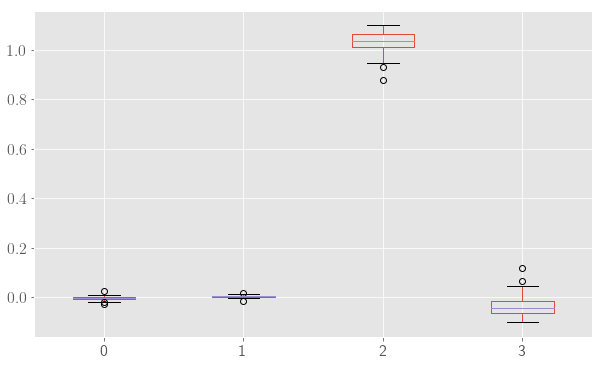

In [113]:
function_to_predict = fList[0]
# calculate data
np.random.seed(1721993)
err = np.random.normal(0, 1, 500)

np.random.seed(0)
x = np.random.uniform(-4, 4, 500)

y = function_to_predict(x)  # + err

regressors = [
    LinearRegression(),
    RandomForestRegressor(),
    GaussianProcessRegressor()]

# calculate data

x = x.reshape((len(x), 1))
x, x_test = np.split(x, 2)
y, y_test = np.split(y, 2)

result = n_experiment(x, y, x_test, y_test, regressors, repeats=100)

plt.figure()
dfC = pd.DataFrame(np.transpose(result["C"]))
dfC.boxplot(return_type='both')
plt.show()


## Numerical Results:
$R^2$ (larger values are better) and standard deviation.

In [114]:
R = result["R"]
Res = np.zeros((len(regressors)+1,2)) 
Res[:, 0] = R.mean(1)
Res[:, 1] = R.std(1)
for res, regressor in zip(Res, regressors):
        print(res, str(regressor.__class__.__name__))



[0.99083448 0.0011553 ] LinearRegression
[5.23459569e-01 1.11022302e-16] RandomForestRegressor
[0.99107362 0.00309178] GaussianProcessRegressor


## Boxplot: $R^2$ Values 

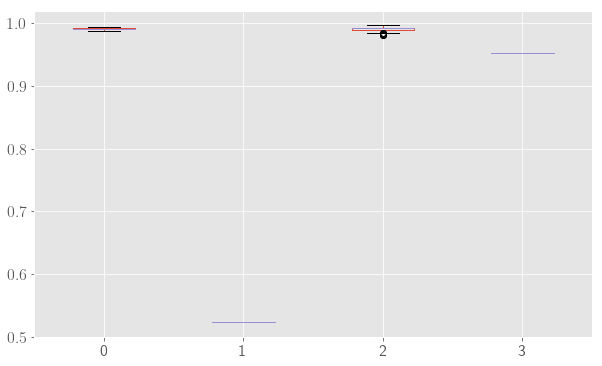

In [115]:
plt.figure()
df = pd.DataFrame(np.transpose(result["R"]))
df.boxplot(return_type='both')
plt.show()

## Experiment 2: Quadratic Function

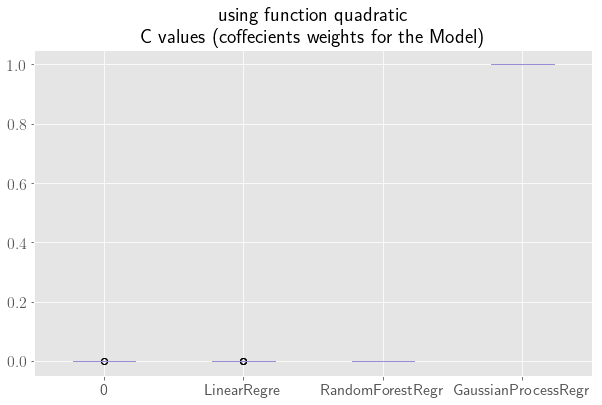

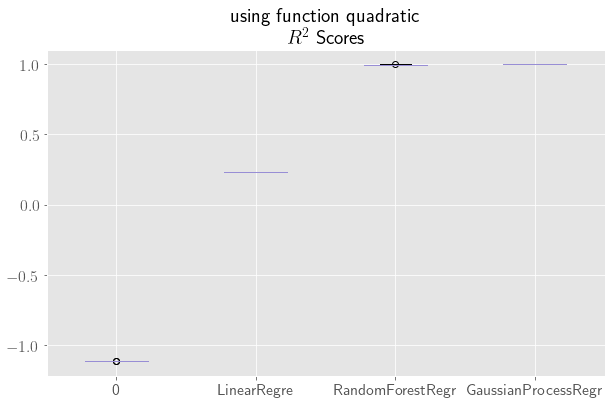

In [116]:
showBoxplot(fList[1])

## Experiment 3: Sine Function

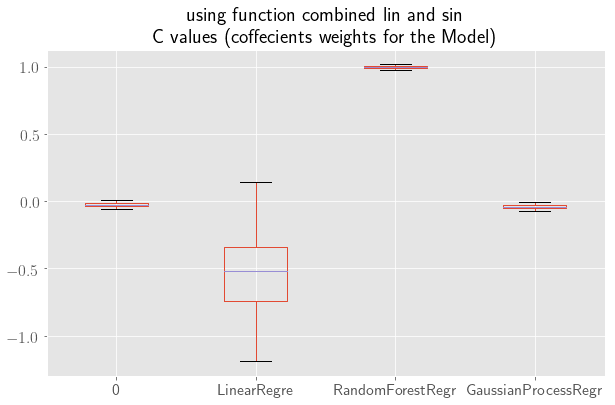

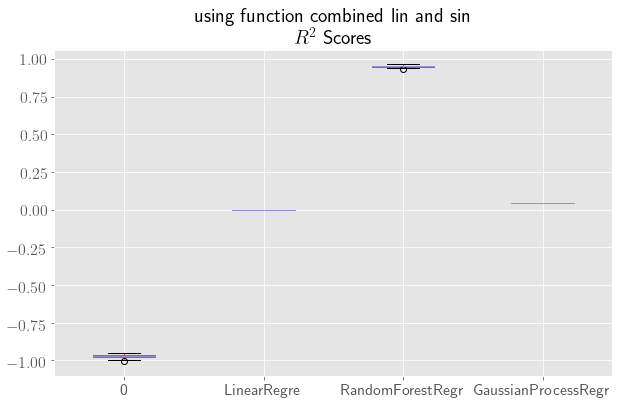

In [117]:
showBoxplot(fList[3])


## Experiment 4: Linear-Sine Function

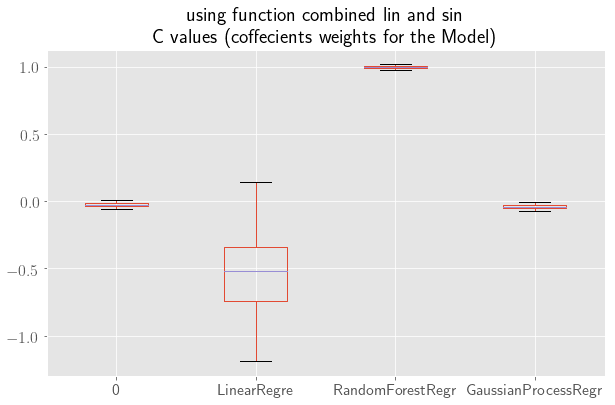

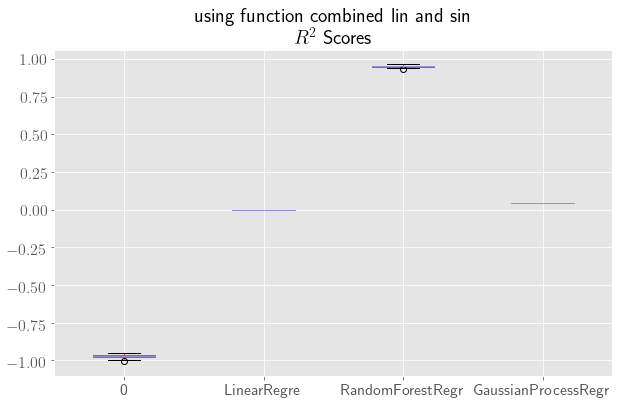

In [118]:
showBoxplot(fList[3])


## Experiment 5: Linear Function

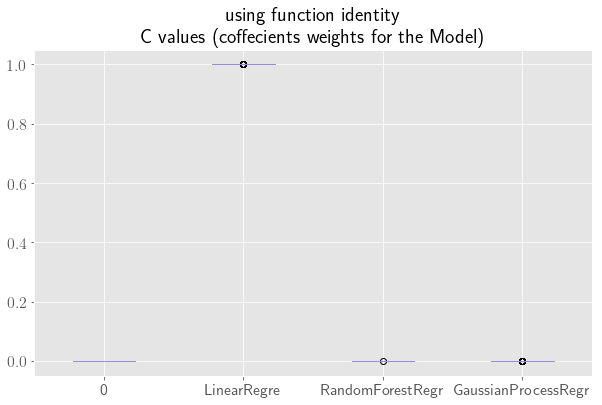

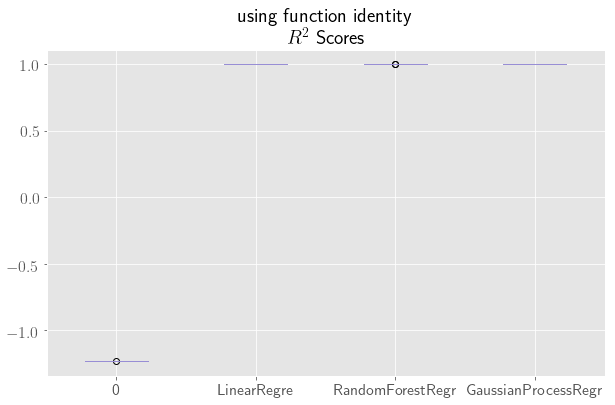

In [119]:
showBoxplot(fList[4])


## Experiment 6: Random Noise (normal)

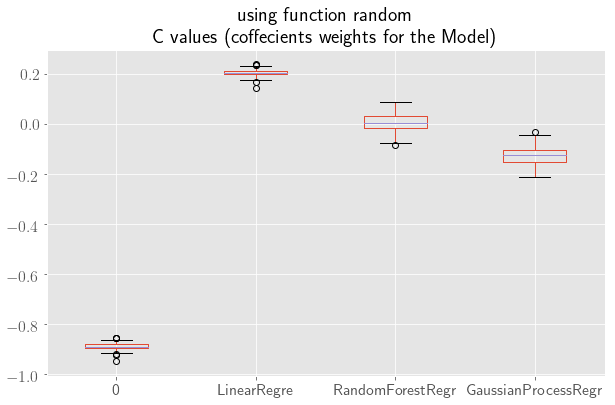

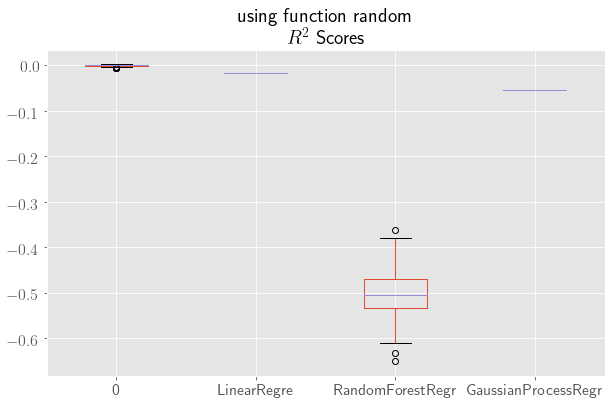

In [120]:
showBoxplot(fList[5])


# Blending
$\Rightarrow$ Slides